In [1]:
%load_ext autoreload
%autoreload 2

import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.v2 import Compose, Normalize, Lambda, Resize, \
    RandomHorizontalFlip, RandomRotation, RandomResizedCrop, ColorJitter, RandomGrayscale
from tqdm.auto import tqdm

device = 'cuda'

/home/xallt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from data import CatDataset
from diffusion import Diffusion, get_named_beta_schedule
from trainer import Trainer
from models.unet import UNet

In [3]:
ds = CatDataset(
    'data/cats_256_aligned',
    transform = Compose([
        Lambda(lambda x: x.float()),
        Resize(64),
        Normalize((127.5,) * 3, (127.5,) * 3),
    ]),
    augmentation = Compose([
        Normalize((-1,) * 3, (2,) * 3),
        RandomHorizontalFlip(),
        RandomRotation(30),
        RandomResizedCrop(64, scale=(0.6, 1.0)),
        Normalize((0.5,) * 3, (0.5,) * 3),
    ])
)

/media/xallt/HardDrive/.virtualenv/catgen/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


sample.shape torch.Size([3, 64, 64])
sample.min() tensor(-0.9941)
sample.max() tensor(1.)


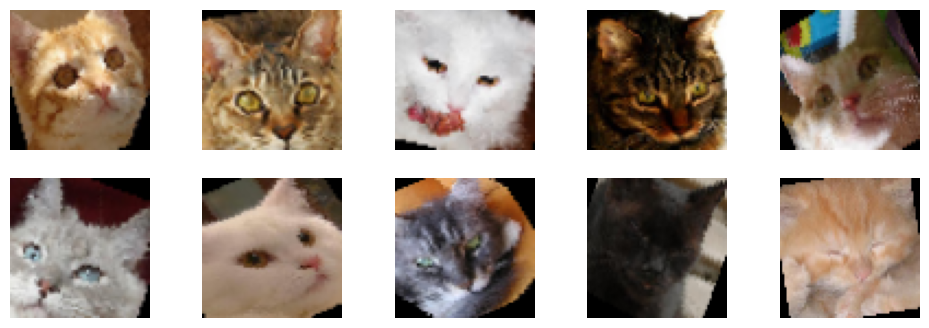

In [4]:
# Inspect dataset
indices = np.random.choice(len(ds), 10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
for i, ax in zip(indices, axes.flatten()):
    ax.imshow(ds.augmentation(ds[i]).permute(1, 2, 0).numpy() * 0.5 + 0.5)
    ax.axis('off')

sample = ds[0]
print("sample.shape", sample.shape)
print("sample.min()", sample.min())
print("sample.max()", sample.max())


In [5]:
from models.vae import Encoder, Decoder, VAE

In [19]:
model = VAE(
    in_channels=3,
    base_channels=16,
    in_resolution=64,
    num_levels=4,
    latent_dim=64, 
    num_blocks_per_level=1,
    dropout=0.1
).cuda()

In [20]:
# Optional
model.load_state_dict(torch.load('checkpoints/vae_64_bad.pt'))

<All keys matched successfully>

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("encoder parameters", count_parameters(model.decoder))
print("decoder parameters", count_parameters(model.encoder))

encoder parameters 1897155
decoder parameters 2551200


In [10]:
trainer = Trainer(
    model,
    ds.train_loader(batch_size=160),
    ds.val_loader(batch_size=64),
    lr=1e-3,
    weight_decay=1e-4,
    num_epochs=100000,
    log_every=1,
    save_every=100,
    device='cuda',
    checkpoint_file='checkpoints/checkpoint_64_512_aug.pt'
)

In [11]:
trainer.run_loop(True)

 82%|████████▏ | 41/50 [00:38<00:08,  1.07it/s]


KeyboardInterrupt: 

# Metrics

In [12]:
from metrics import compute_metrics

In [18]:
compute_metrics(ds.test_loader(batch_size=64), model, fid_num_samples=1000)

  0%|          | 0/16 [00:00<?, ?it/s]/media/xallt/HardDrive/.virtualenv/catgen/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 16/16 [00:01<00:00,  8.11it/s]
/media/xallt/HardDrive/.virtualenv/catgen/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 

{'ssim': 0.003419907750548782, 'fid': 126.86805001902344}